# Machine Learning Explainability  
*Extract human-understandable insights from any machine learning model.*

# 1. Use Cases for Model Insights  
*Why and when do you need insights?*  

## What Types of Insights Are Possible  

What Types of Insights Are Possible

Many people say machine learning models are "black boxes", in the sense that they can make good predictions but you can't understand the logic behind those predictions. This statement is true in the sense that most data scientists don't know how to extract insights from models yet.

However, this micro-course will teach you techniques to extract the following insights from sophisticated machine learning models.
- What features in the data did the model think are most important?
- For any single prediction from a model, how did each feature in the data affect that particular prediction?
- How does each feature affect the model's predictions in a big-picture sense (what is its typical effect when considered over a large number of possible predictions)?

## Why Are These Insights Valuable

These insights have many uses, including
- Debugging
- Informing feature engineering
- Directing future data collection
- Informing human decision-making
- Building Trust

### Debugging

The world has a lot of unreliable, disorganized and generally dirty data. You add a potential source of errors as you write preprocessing code. Add in the potential for target leakage, and it is the norm rather than the exception to have errors at some point in a real data science project.

Given the frequency and potentially disastrous consequences of bugs, debugging is one of the most valuable skills in data science. Understanding the patterns a model is finding will help you identify when those are at odds with your knowledge of the real world, and this is typically the first step in tracking down bugs.

### Informing Feature Engineering

Feature engineering is usually the most effective way to improve model accuracy. Feature engineering usually involves repeatedly creating new features using transformations of your raw data or features you have previously created.

Sometimes you can go through this process using nothing but intuition about the underlying topic. But you'll need more direction when you have 100s of raw features or when you lack background knowledge about the topic you are working on.

A Kaggle competition to predict loan defaults gives an extreme example. This competition had 100s of raw features. For privacy reasons, the features had names like `f1`, `f2`, `f3` rather than common English names. This simulated a scenario where you have little intuition about the raw data.

One competitor found that the difference between two of the features, specifically `f527 - f528`, created a very powerful new feature. Models including that difference as a feature were far better than models without it. But how might you think of creating this variable when you start with hundreds of variables?

The techniques you'll learn in this micro-course would make it transparent that `f527` and `f528` are important features, and that their role is tightly entangled. This will direct you to consider transformations of these two variables, and likely find the "golden feature" of `f527` - `f528`.

As an increasing number of datasets start with 100s or 1000s of raw features, this approach is becoming increasingly important.

### Directing Future Data Collection

You have no control over datasets you download online. But many businesses and organizations using data science have opportunities to expand what types of data they collect. Collecting new types of data can be expensive or inconvenient, so they only want to do this if they know it will be worthwhile. Model-based insights give you a good understanding of the value of features you currently have, which will help you reason about what new values may be most helpful.

### Informing Human Decision-Making

Some decisions are made automatically by models. Amazon doesn't have humans (or elves) scurry to decide what to show you whenever you go to their website. But many important decisions are made by humans. For these decisions, insights can be more valuable than predictions.

### Building Trust

Many people won't assume they can trust your model for important decisions without verifying some basic facts. This is a smart precaution given the frequency of data errors. In practice, showing insights that fit their general understanding of the problem will help build trust, even among people with little deep knowledge of data science.

# 2. Permutation Importance  
*What features does your model think are important?*

## Introduction

One of the most basic questions we might ask of a model is: What features have the biggest impact on predictions?

This concept is called **feature importance**.

There are multiple ways to measure feature importance. Some approaches answer subtly different versions of the question above. Other approaches have documented shortcomings.

In this lesson, we'll focus on **permutation importance**. Compared to most other approaches, permutation importance is:
- fast to calculate,
- widely used and understood, and
- consistent with properties we would want a feature importance measure to have.

## How It Works

Permutation importance uses models differently than anything you've seen so far, and many people find it confusing at first. So we'll start with an example to make it more concrete.

Consider data with the following format:

| Height at age 20 (cm)| Height at age 10 (cm)| ... | Socks owned at age 10|
|:----------------------|----------------------|-----|----------------------|
| 182|185|...|20|
|175|147|...|10|
|...|...|...|...|
|156|142|...|8|
|153|130|...|24|

We want to predict a person's height when they become 20 years old, using data that is available at age 10.

Our data includes useful features (height at age 10), features with little predictive power (socks owned), as well as some other features we won't focus on in this explanation.

**Permutation importance is calculated after a model has been fitted.** So we won't change the model or change what predictions we'd get for a given value of height, sock-count, etc.

Instead we will ask the following question: If I randomly shuffle a single column of the validation data, leaving the target and all other columns in place, how would that affect the accuracy of predictions in that now-shuffled data?

Randomly re-ordering a single column should cause less accurate predictions, since the resulting data no longer corresponds to anything observed in the real world. Model accuracy especially suffers if we shuffle a column that the model relied on heavily for predictions. In this case, shuffling `height at age 10` would cause terrible predictions. If we shuffled `socks owned` instead, the resulting predictions wouldn't suffer nearly as much.

With this insight, the process is as follows:

- Get a trained model.
- Shuffle the values in a single column, make predictions using the resulting dataset. Use these predictions and the true target values to calculate how much the loss function suffered from shuffling. That performance deterioration measures the importance of the variable you just shuffled.
- Return the data to the original order (undoing the shuffle from step 2). Now repeat step 2 with the next column in the dataset, until you have calculated the importance of each column.

### Code Example 

Our example will use a model that predicts whether a soccer/football team will have the "Man of the Game" winner based on the team's statistics. The "Man of the Game" award is given to the best player in the game. Model-building isn't our current focus, so the cell below loads the data and builds a rudimentary model.

In [5]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

data = pd.read_csv('C:\\users\\fdoli\\github\\Kaggle\\FIFA2018MatchStats\\Fifa_2018_Statistics.csv')
y = (data['Man of the Match'] == 'Yes') # Convert from string to int
feature_names = [i for i in data.columns if data[i].dtype in [np.int64]]
X = data[feature_names]
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=1)
my_model = RandomForestClassifier(n_estimators=100, random_state=0).fit(train_X, train_y)

Here is how to calculate and show importances with the **eli5** library:

In [8]:
data.head()

,Date,Team,Opponent,Goal Scored,Ball Possession %,Attempts,On-Target,Off-Target,Blocked,Corners,...,Yellow Card,Yellow & Red,Red,Man of the Match,1st Goal,Round,PSO,Goals in PSO,Own goals,Own goal Time
0,14-06-2018,Russia,Saudi Arabia,5,40,13,7,3,3,6,...,0,0,0,Yes,12.0,Group Stage,No,0,NaN,NaN
1,14-06-2018,Saudi Arabia,Russia,0,60,6,0,3,3,2,...,0,0,0,No,NaN,Group Stage,No,0,NaN,NaN
2,15-06-2018,Egypt,Uruguay,0,43,8,3,3,2,0,...,2,0,0,No,NaN,Group Stage,No,0,NaN,NaN
3,15-06-2018,Uruguay,Egypt,1,57,14,4,6,4,5,...,0,0,0,Yes,89.0,Group Stage,No,0,NaN,NaN
4,15-06-2018,Morocco,Iran,0,64,13,3,6,4,5,...,1,0,0,No,NaN,Group Stage,No,0,1.0,90.0


In [9]:
data.describe()

,Goal Scored,Ball Possession %,Attempts,On-Target,Off-Target,Blocked,Corners,Offsides,Free Kicks,Saves,...,Passes,Distance Covered (Kms),Fouls Committed,Yellow Card,Yellow & Red,Red,1st Goal,Goals in PSO,Own goals,Own goal Time
count,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,...,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,94.000000,128.000000,12.0,12.000000
mean,1.320312,49.992188,12.593750,3.914062,5.273438,3.359375,4.718750,1.343750,14.890625,2.726562,...,462.648438,106.664062,13.546875,1.695312,0.015625,0.015625,39.457447,0.203125,1.0,45.833333
std,1.156519,10.444074,5.245827,2.234403,2.409675,2.403195,2.446072,1.193404,4.724262,2.049447,...,151.186311,11.749537,4.619131,1.325454,0.124507,0.124507,24.496506,0.807049,0.0,29.978275
min,0.000000,25.000000,3.000000,0.000000,1.000000,0.000000,0.000000,0.000000,5.000000,0.000000,...,189.000000,80.000000,5.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.0,12.000000
25%,0.000000,42.000000,9.000000,2.000000,4.000000,1.750000,3.000000,0.000000,11.000000,1.000000,...,351.000000,101.000000,10.000000,1.000000,0.000000,0.000000,18.250000,0.000000,1.0,21.750000
50%,1.000000,50.000000,12.000000,3.500000,5.000000,3.000000,5.000000,1.000000,15.000000,2.000000,...,462.000000,104.500000,13.000000,2.000000,0.000000,0.000000,39.000000,0.000000,1.0,35.000000
75%,2.000000,58.000000,15.000000,5.000000,7.000000,4.000000,6.000000,2.000000,18.000000,4.000000,...,555.250000,109.000000,16.000000,2.000000,0.000000,0.000000,54.750000,0.000000,1.0,75.750000
max,6.000000,75.000000,26.000000,12.000000,11.000000,10.000000,11.000000,5.000000,26.000000,9.000000,...,1137.000000,148.000000,25.000000,6.000000,1.000000,1.000000,90.000000,4.000000,1.0,90.000000


In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128 entries, 0 to 127
Data columns (total 27 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Date                    128 non-null    object 
 1   Team                    128 non-null    object 
 2   Opponent                128 non-null    object 
 3   Goal Scored             128 non-null    int64  
 4   Ball Possession %       128 non-null    int64  
 5   Attempts                128 non-null    int64  
 6   On-Target               128 non-null    int64  
 7   Off-Target              128 non-null    int64  
 8   Blocked                 128 non-null    int64  
 9   Corners                 128 non-null    int64  
 10  Offsides                128 non-null    int64  
 11  Free Kicks              128 non-null    int64  
 12  Saves                   128 non-null    int64  
 13  Pass Accuracy %         128 non-null    int64  
 14  Passes                  128 non-null    in

In [11]:
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(my_model, random_state=1).fit(val_X, val_y)
eli5.show_weights(perm, feature_names=val_X.columns.tolist())

Weight,Feature
0.1750 ± 0.0848,Goal Scored
0.0500 ± 0.0637,Distance Covered (Kms)
0.0437 ± 0.0637,Yellow Card
0.0187 ± 0.0500,Off-Target
0.0187 ± 0.0637,Free Kicks
0.0187 ± 0.0637,Fouls Committed
0.0125 ± 0.0637,Pass Accuracy %
0.0125 ± 0.0306,Blocked
0.0063 ± 0.0612,Saves
0.0063 ± 0.0250,Ball Possession %


### Interpreting Permutation Importances

The values towards the top are the most important features, and those towards the bottom matter least.

The first number in each row shows how much model performance decreased with a random shuffling (in this case, using "accuracy" as the performance metric).

Like most things in data science, there is some randomness to the exact performance change from a shuffling a column. We measure the amount of randomness in our permutation importance calculation by repeating the process with multiple shuffles. The number after the **±** measures how performance varied from one-reshuffling to the next.

You'll occasionally see negative values for permutation importances. In those cases, the predictions on the shuffled (or noisy) data happened to be more accurate than the real data. This happens when the feature didn't matter (should have had an importance close to 0), but random chance caused the predictions on shuffled data to be more accurate. This is more common with small datasets, like the one in this example, because there is more room for luck/chance.

In our example, the most important feature was **Goals scored**. That seems sensible. Soccer fans may have some intuition about whether the orderings of other variables are surprising or not.

---
# 3. Partial Plots  
*How does each feature affect your predictions?*

## Partial Dependence Plots

While feature importance shows what variables most affect predictions, partial dependence plots show how a feature affects predictions.

This is useful to answer questions like:
- Controlling for all other house features, what impact do longitude and latitude have on home prices? To restate this, how would similarly sized houses be priced in different areas?
- Are predicted health differences between two groups due to differences in their diets, or due to some other factor?

If you are familiar with linear or logistic regression models, partial dependence plots can be interpreted similarly to the coefficients in those models. Though, partial dependence plots on sophisticated models can capture more complex patterns than coefficients from simple models. If you aren't familiar with linear or logistic regressions, don't worry about this comparison.

We will show a couple examples, explain the interpretation of these plots, and then review the code to create these plots.

## How It Works

Like permutation importance, **partial dependence plots are calculated after a model has been fit**. The model is fit on real data that has not been artificially manipulated in any way.

In our soccer example, teams may differ in many ways. How many passes they made, shots they took, goals they scored, etc. At first glance, it seems difficult to disentangle the effect of these features.

To see how partial plots separate out the effect of each feature, we start by considering a single row of data. For example, that row of data might represent a team that had the ball 50% of the time, made 100 passes, took 10 shots and scored 1 goal.

We will use the fitted model to predict our outcome (probability their player won "man of the match"). But we repeatedly alter the value for one variable to make a series of predictions. We could predict the outcome if the team had the ball only 40% of the time. We then predict with them having the ball 50% of the time. Then predict again for 60%. And so on. We trace out predicted outcomes (on the vertical axis) as we move from small values of ball possession to large values (on the horizontal axis).

In this description, we used only a single row of data. Interactions between features may cause the plot for a single row to be atypical. So, we repeat that mental experiment with multiple rows from the original dataset, and we plot the average predicted outcome on the vertical axis.

## Code Example

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

data = pd.read_csv('C:\\users\\fdoli\\github\\Kaggle\\FIFA2018MatchStats\\Fifa_2018_Statistics.csv')
y = (data['Man of the Match'] == 'Yes')
feature_names = [i for i in data.columns if data[i].dtype in [np.int64]]
X = data[feature_names]
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=1)
tree_model = DecisionTreeClassifier(random_state=0, max_depth=5, min_samples_split=5).fit(train_X, train_y)

Our first example uses a decision tree, which you can see below. In practice, you'll use more sophistated models for real-world applications.

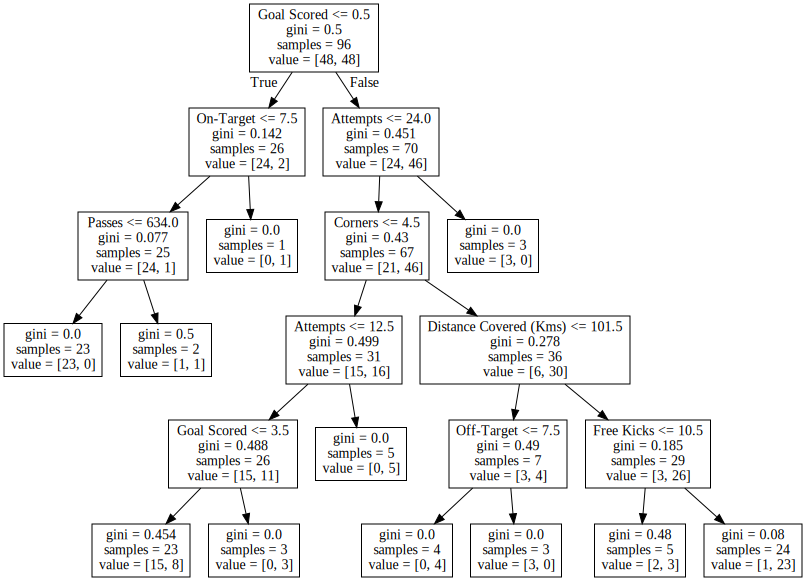

In [2]:
from sklearn import tree
import graphviz

tree_graph = tree.export_graphviz(tree_model, out_file=None, feature_names=feature_names)
graphviz.Source(tree_graph)

As guidance to read the tree:
- Leaves with children show their splitting criterion on the top
- The pair of values at the bottom show the count of False values and True values for the target respectively, of data points in that node of the tree.

Here is the code to create the Partial Dependence Plot using the PDPBox library.

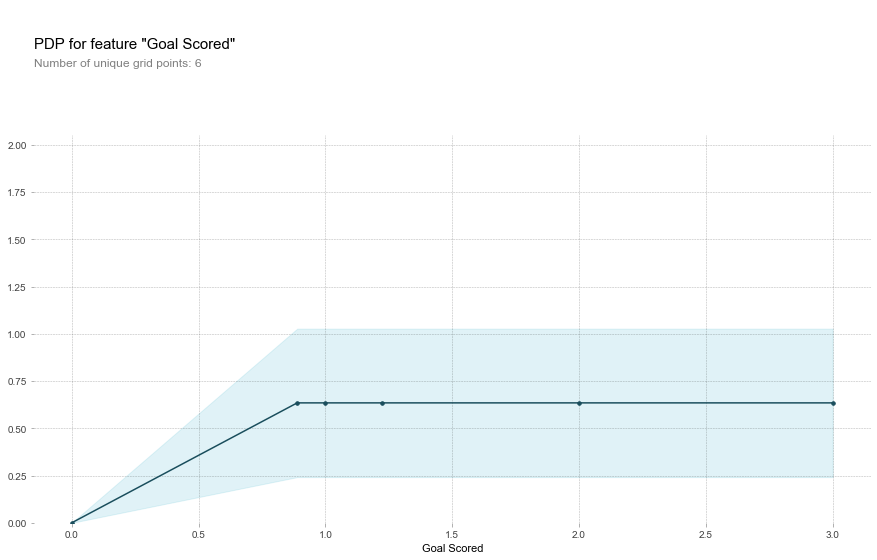

In [4]:
from matplotlib import pyplot as plt
from pdpbox import pdp, get_dataset, info_plots

# Create the data that we will plot
pdp_goals = pdp.pdp_isolate(model=tree_model, dataset=val_X, model_features=feature_names, feature='Goal Scored')

# plot it!
pdp.pdp_plot(pdp_goals, 'Goal Scored')
plt.show()

A few items are worth pointing out as you interpret this plot
- The y axis is interpreted as change in the prediction from what it would be predicted at the baseline or leftmost value.
- A blue shaded area indicates level of confidence

From this particular graph, we see that scoring a goal substantially increases your chances of winning "Man of The Match." But extra goals beyond that appear to have little impact on predictions.

Here is another example plot:

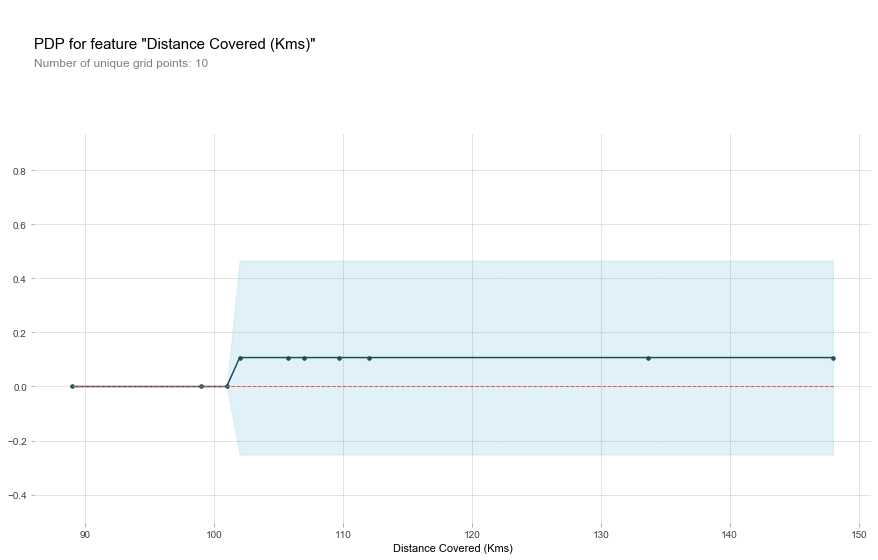

In [6]:
feature_to_plot = 'Distance Covered (Kms)'
pdp_dist = pdp.pdp_isolate(model=tree_model, dataset=val_X, model_features=feature_names, feature=feature_to_plot)

pdp.pdp_plot(pdp_dist, feature_to_plot)
plt.show()

This graph seems too simple to represent reality. But that's because the model is so simple. You should be able to see from the decision tree above that this is representing exactly the model's structure.

You can easily compare the structure or implications of different models. Here is the same plot with a Random Forest model.

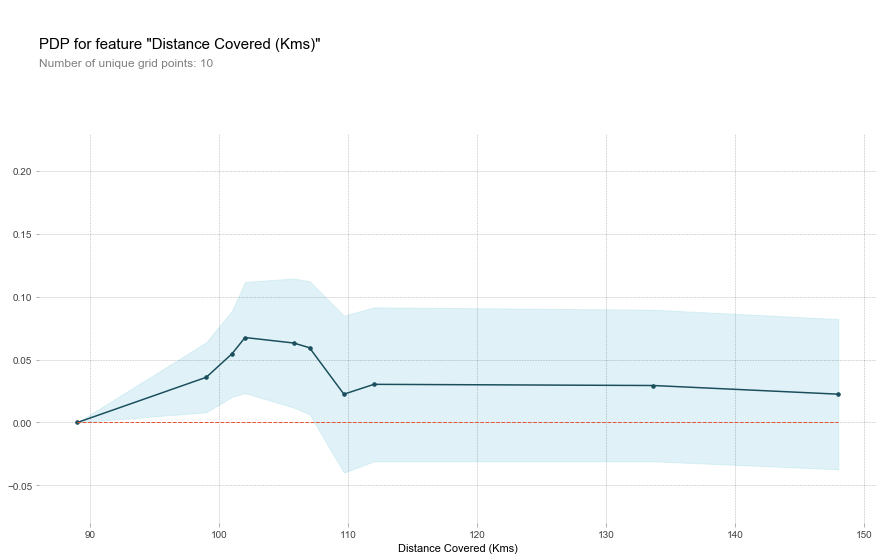

In [7]:
# Build a Random Forest model
rf_model = RandomForestClassifier(random_state=0).fit(train_X, train_y)

pdp_dist = pdp.pdp_isolate(model=rf_model, dataset=val_X, model_features=feature_names, feature=feature_to_plot)

pdp.pdp_plot(pdp_dist, feature_to_plot)
plt.show()

This model thinks you are more likely to win Man of the Match if your players run a total of 100km over the course of the game. Though running much more causes lower predictions.

In general, the smooth shape of this curve seems more plausible than the step function from the Decision Tree model. Though this dataset is small enough that we would be careful in how we interpret any model.

# 2D Partial Dependence Plots

If you are curious about interactions between features, 2D partial dependence plots are also useful. An example may clarify this.

We will again use the Decision Tree model for this graph. It will create an extremely simple plot, but you should be able to match what you see in the plot to the tree itself.


TypeError: clabel() got an unexpected keyword argument 'contour_label_fontsize'

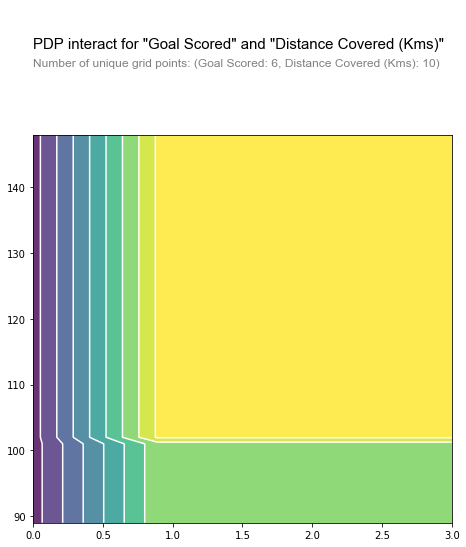

In [17]:
# Similar to previous PDP plot except we use pdp_interact instead of pdp_isolate and pdp_interact_plot instead of pdp_plot
features_to_plot = ['Goal Scored', 'Distance Covered (Kms)']
inter1 = pdp.pdp_interact(model=tree_model, dataset=val_X, model_features=feature_names, features=features_to_plot)

pdp.pdp_interact_plot(pdp_interact_out=inter1, feature_names=features_to_plot)
plt.show()

### NOTE: there is a problem with the pdpbox library, that's why the plot has problems.


This graph shows predictions for any combination of Goals Scored and Distance covered.

For example, we see the highest predictions when a team scores at least 1 goal and they run a total distance close to 100km. If they score 0 goals, distance covered doesn't matter. Can you see this by tracing through the decision tree with 0 goals?

But distance can impact predictions if they score goals. Make sure you can see this from the 2D partial dependence plot. Can you see this pattern in the decision tree too?


### Notes from exercises:  

*Permutation Importance* relies on the values we have stored in our data set for that studied feature. So if we have a single value 99% of the time, that implies the *Permutation Importance* for that feature will be lower. This is independent of the effect of the Partial Plot for the same feature, which can have a great effect for the values it changes (which might be a few).

If we have interactions between the features and the target, the partial plot (pdp) features will be atypical. In the case of direct interaction (`y = X1 * X2`), the pdp feature is flat. But, the Permutation Importance will be large, because changing the entries for a single feature, will cause to drastically change the outcome of the prediction for `y` as it was built directly from the features `X1` and `X2`.

In [47]:
n_samples = 10
X1 = 4 * np.random.rand(n_samples) - 2
X2 = 4 * np.random.rand(n_samples) - 2
y = X1 * X2

my_df = pd.DataFrame({'X1': X1, 'X2': X2, 'y': y})

In [48]:
my_df

,X1,X2,y
0,0.499366,-0.219150,-0.109436
1,-1.307910,-1.850090,2.419751
2,-1.525979,-1.736053,2.649181
3,-0.911378,-1.149272,1.047422
4,1.670377,-0.758549,-1.267064
5,0.809962,-0.989970,-0.801838
6,-0.161724,-0.135003,0.021833
7,-1.635140,0.438733,-0.717389
8,-1.782540,1.862046,-3.319172
9,1.569545,1.076015,1.688854


In [44]:
np.array(liste) * -1

array([ 0, -1, -2, -3, -4])

---
# 4. SHAP Values
*Understand individual predictions*


# Intro

What if you want to break down how the model works for an individual prediction?

SHAP Values (an acronym from SHapley Additive exPlanations) break down a prediction to show the impact of each feature. Where could you use this?

- A model says a bank shouldn't loan someone money, and the bank is legally required to explain the basis for each loan rejection
- A healthcare provider wants to identify what factors are driving each patient's risk of some disease so they can directly address those risk factors with targeted health interventions

You'll use SHAP Values to explain individual predictions in this lesson. In the next lesson, you'll see how these can be aggregated into powerful model-level insights.

# How They Work

SHAP values interpret the impact of having a certain value for a given feature in comparison to the prediction we'd make if that feature took some baseline value.

An example is helpful, and we'll continue the soccer/football example from the permutation importance and partial dependence plots lessons.

In these tutorials, we predicted whether a team would have a player win the *Man of the Match* award.

We could ask:

- How much was a prediction driven by the fact that the team scored 3 goals?

But it's easier to give a concrete, numeric answer if we restate this as:

- How much was a prediction driven by the fact that the team scored 3 goals, **instead of some baseline number of goals**.

Of course, each team has many features. So if we answer this question for `number of goals`, we could repeat the process for all other features.

SHAP values do this in a way that guarantees a nice property. Specifically, you decompose a prediction with the following equation:

`sum(SHAP values for all features) = pred_for_team - pred_for_baseline_values`

That is, the SHAP values of all features sum up to explain why my prediction was different from the baseline. This allows us to decompose a prediction in a graph like this:

![SHAP](FIFA2018MatchStats\SHAP.png)



How do you interpret this?

We predicted 0.7, whereas the base_value is 0.4979. Feature values causing increased predictions are in pink, and their visual size shows the magnitude of the feature's effect. Feature values decreasing the prediction are in blue. The biggest impact comes from `Goal Scored` being 2. Though the ball possession value has a meaningful effect decreasing the prediction.

If you subtract the length of the blue bars from the length of the pink bars, it equals the distance from the base value to the output.

There is some complexity to the technique, to ensure that the baseline plus the sum of individual effects adds up to the prediction (which isn't as straightforward as it sounds). We won't go into that detail here, since it isn't critical for using the technique. This [blog post](https://towardsdatascience.com/one-feature-attribution-method-to-supposedly-rule-them-all-shapley-values-f3e04534983d) has a longer theoretical explanation.

# Code to Calculate SHAP Values

We calculate SHAP values using the wonderful [Shap](https://github.com/slundberg/shap) library.

For this example, we'll reuse the model you've already seen with the Soccer data.

In [4]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

data = pd.read_csv('C:\\users\\fdoli\\github\\Kaggle\\FIFA2018MatchStats\\Fifa_2018_Statistics.csv')
y = (data['Man of the Match'] == 'Yes') # Convert from string to int
feature_names = [i for i in data.columns if data[i].dtype in [np.int64]]
X = data[feature_names]
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=1)
my_model = RandomForestClassifier(n_estimators=10, random_state=0).fit(train_X, train_y)

We will look at SHAP values for a single row of the dataset (we arbitrarily chose row 5). For context, we'll look at the raw predictions before looking at the SHAP values.

In [5]:
row_to_show = 5
data_for_prediction = val_X.iloc[row_to_show] # use 1 row of data here. Could use multiple rows if desired
data_for_prediction_array = data_for_prediction.values.reshape(1, -1)

my_model.predict_proba(data_for_prediction_array)

array([[0.3, 0.7]])

The team is 70% likely to have a player win the award.

Now, we'll move onto the code to get SHAP values for that single prediction.

In [7]:
import shap

# Create object that can calculate shap values
explainer = shap.TreeExplainer(my_model)

# Calculate Shap values
shap_values = explainer.shap_values(data_for_prediction)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


The `shap_values` object above is a list with two arrays. The first array is the SHAP values for a negative outcome (don't win the award), and the second array is the list of SHAP values for the positive outcome (wins the award). We typically think about predictions in terms of the prediction of a positive outcome, so we'll pull out SHAP values for positive outcomes (pulling out `shap_values[1]`).

It's cumbersome to review raw arrays, but the shap package has a nice way to visualize the results.

In [8]:
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], data_for_prediction)

If you look carefully at the code where we created the SHAP values, you'll notice we reference Trees in `shap.TreeExplainer(my_model)`. But the SHAP package has explainers for every type of model.

- shap.DeepExplainer works with Deep Learning models.
- shap.KernelExplainer works with all models, though it is slower than other Explainers and it offers an approximation rather than exact Shap values.

Here is an example using `KernelExplainer` to get similar results. The results aren't identical because `KernelExplainer` gives an approximate result. But the results tell the same story.

In [10]:
# use Kernel SHAP to explain test set predictions
k_explainer = shap.KernelExplainer(my_model.predict_proba, train_X)
k_shap_values = k_explainer.shap_values(data_for_prediction)
shap.force_plot(k_explainer.expected_value[1], k_shap_values[1], data_for_prediction)

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!


---
# 5. Advanced Uses of SHAP Values
*Aggregate SHAP values for even more detailed model insights*


# Recap  

We started by learning about permutation importance and partial dependence plots for an overview of what the model has learned.

We then learned about SHAP values to break down the components of individual predictions.

Now we'll expand on SHAP values, seeing how aggregating many SHAP values can give more detailed alternatives to permutation importance and partial dependence plots.

# SHAP Values Review  
Shap values show how much a given feature changed our prediction (compared to if we made that prediction at some baseline value of that feature).

For example, consider an ultra-simple model: 
$$y=4\cdot x1 + 2 \cdot x2$$

If $x1$ takes the value 2, instead of a baseline value of 0, then our SHAP value for $x1$ would be 8 (from 4 times 2).

These are harder to calculate with the sophisticated models we use in practice. But through some algorithmic cleverness, Shap values allow us to decompose any prediction into the sum of effects of each feature value, yielding a graph like this:

![SHAP2](FIFA2018MatchStats\SHAP2.png)

In addition to this nice breakdown for each prediction, the Shap library offers great visualizations of groups of Shap values. We will focus on two of these visualizations. These visualizations have conceptual similarities to permutation importance and partial dependence plots. So multiple threads from the previous exercises will come together here.

# Summary Plots

Permutation importance is great because it created simple numeric measures to see which features mattered to a model. This helped us make comparisons between features easily, and you can present the resulting graphs to non-technical audiences.

But it doesn't tell you how each features matter. If a feature has medium permutation importance, that could mean it has

- a large effect for a few predictions, but no effect in general, or
- a medium effect for all predictions.

SHAP summary plots give us a birds-eye view of feature importance and what is driving it. We'll walk through an example plot for the soccer data:

![SHAPSP](FIFA2018MAtchStats\SHAPSP.png)

This plot is made of many dots. Each dot has three characteristics:

- Vertical location shows what feature it is depicting
- Color shows whether that feature was high or low for that row of the dataset
- Horizontal location shows whether the effect of that value caused a higher or lower prediction.

For example, the point in the upper left was for a team that scored few goals, reducing the prediction by 0.25.

Some things you should be able to easily pick out:

- The model ignored the `Red` and `Yellow & Red` features.
- Usually `Yellow Card` doesn't affect the prediction, but there is an extreme case where a high value caused a much lower prediction.
- High values of Goal scored caused higher predictions, and low values caused low predictions

If you look for long enough, there's a lot of information in this graph. You'll face some questions to test how you read them in the exercise.

# Summary Plots in Code

In [11]:
# We load the data
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

data = pd.read_csv('C:\\users\\fdoli\\github\\Kaggle\\FIFA2018MatchStats\\Fifa_2018_Statistics.csv')
y = (data['Man of the Match'] == 'Yes') # Convert from string to int
feature_names = [i for i in data.columns if data[i].dtype in [np.int64]]
X = data[feature_names]
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=1)
my_model = RandomForestClassifier(n_estimators=10, random_state=0).fit(train_X, train_y)

We get the SHAP values for all validation data with the following code. It is short enough that we explain it in the comments.

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


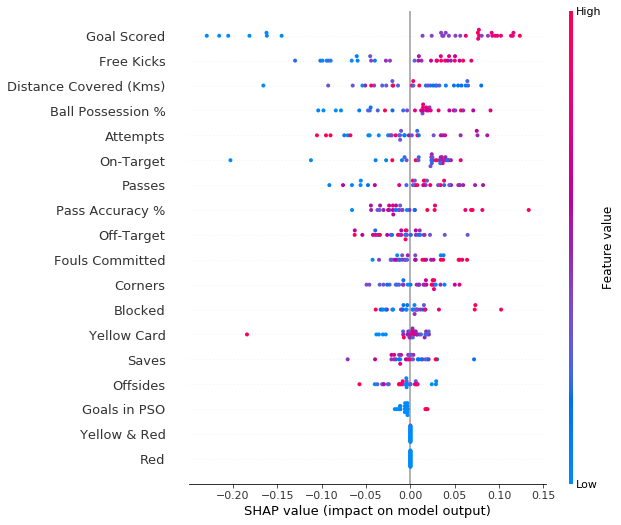

In [12]:
import shap

# Create object that can calculate shap values
explainer = shap.TreeExplainer(my_model)

# Calculate shap values. This is what we will plot
# Calculate shap_values for all val_X rather than a single row, to have more data to plot
shap_values = explainer.shap_values(val_X)

# make plot. Index of [1] is explained in the text below
shap.summary_plot(shap_values[1], val_X)

The code isn't too complex. But there are a few caveats.
- When plotting, we call `shap_values[1]`. For classification problems, there is a separate array of SHAP values for each possible outcome. In this case, we index in to get the SHAP values for the prediction of "True".
- Calculating SHAP values can be slow. It isn't a problem here, because this dataset is small. But you'll want to be careful when running these to plot with reasonably sized datasets. The exception is when using an `xgboost` model, which SHAP has some optimizations for and which is thus much faster.

This provides a great overview of the model, but we might want to delve into a single feature. That's where SHAP dependence contribution plots come into play.

# SHAP Dependence Contribution Plots

We've previously used Partial Dependence Plots to show how a single feature impacts predictions. These are insightful and relevant for many real-world use cases. Plus, with a little effort, they can be explained to a non-technical audience.

But there's a lot they don't show. For instance, what is the distribution of effects? Is the effect of having a certain value pretty constant, or does it vary a lot depending on the values of other feaures. SHAP dependence contribution plots provide a similar insight to PDP's, but they add a lot more detail.

![SHAPDCP](FIFA2018MAtchStats\SHAPDCP.png)

Start by focusing on the shape, and we'll come back to color in a minute. Each dot represents a row of the data. The horizontal location is the actual value from the dataset, and the vertical location shows what having that value did to the prediction. The fact this slopes upward says that the more you possess the ball, the higher the model's prediction is for winning the *Man of the Match* award.

The spread suggests that other features must interact with Ball Possession %. For example, here we have highlighted two points with similar ball possession values. That value caused one prediction to increase, and it caused the other prediction to decrease.

![SHAPDCP2](FIFA2018MAtchStats\SHAPDCP2.png)

For comparison, a simple linear regression would produce plots that are perfect lines, without this spread.

This suggests we delve into the interactions, and the plots include color coding to help do that. While the primary trend is upward, you can visually inspect whether that varies by dot color.

Consider the following very narrow example for concreteness.

![SHAPDCP3](FIFA2018MAtchStats\SHAPDCP3.png)

These two points stand out spatially as being far away from the upward trend. They are both colored purple, indicating the team scored one goal. You can interpret this to say: **In general, having the ball increases a team's chance of having their player win the award. But if they only score one goal, that trend reverses and the award judges may penalize them for having the ball so much if they score that little**.

Outside of those few outliers, the interaction indicated by color isn't very dramatic here. But sometimes it will jump out at you.

# Dependence Contribution Plots in Code

We get the dependence contribution plot with the following code. The only line that's different from the `summary_plot` is the last line.

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


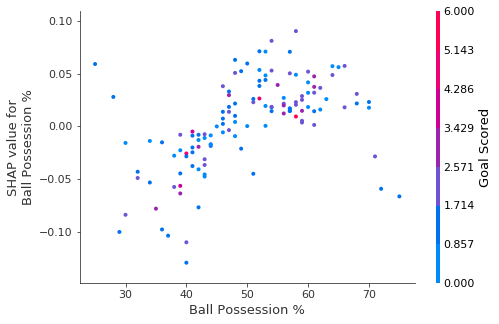

In [13]:
import shap

explainer = shap.TreeExplainer(my_model)
shap_values = explainer.shap_values(X)
shap.dependence_plot('Ball Possession %', shap_values[1], X, interaction_index='Goal Scored')

If you don't supply an argument for interaction_index, Shapley uses some logic to pick one that may be interesting.

This didn't require writing a lot of code. But the trick with these techniques is in thinking critically about the results rather than writing code itself.

## Notes from exercises

### Question 2

Do you believe the range of effects sizes (distance between smallest effect and largest effect) is a good indication of which feature will have a higher permutation importance? Why or why not? 

The width of the effects range is not a reasonable approximation to permutation importance. For that matter, the width of the range doesn't map well to any intuitive sense of "importance" because it can be determined by just a few outliers. However if all dots on the graph are widely spread from each other, that is a reasonable indication that permutation importance is high. Because the range of effects is so sensitive to outliers, permutation importance is a better measure of what's generally important to the model.

